Implementation of an algorithm to prepare a Gaussian state on a quantum computer, as described in the paper by A. Kitaev and W. Webb: https://arxiv.org/abs/0801.0342. The algorithm below is slightly modified from the original, and replaces the supplementary memory qubits with N-level controlled operations.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools
from pyquil.quil import Program
import pyquil.api as api

In [2]:
def norm_(sigma_, mu_, N):
   """
   Normalization factor for the state. Defined in Eq (7) of paper.
   
   Inputs:-
   sigma_: standard deviation
   mu_: mean
   N: cutoff the for the infinite sum, i.e. sum_{i=-N}^{i=N} (...)
   """
   return np.sum(np.exp((-(np.arange(-N, N+1, 1) - mu_)**2)/float(sigma_**2)))

def angle_(sigma_, mu_, N=10**3):
    """
    The angle $\alpha$ defined in Eq (12)
    """
    return np.arccos(np.sqrt(norm_(sigma_/2., mu_/2., N)/norm_(sigma_, mu_, N)))

def qubit_strings(n):
    """
    Return list of strings for n-qubit states in increasing lexicographic order
    """
    qubit_strings = []
    for q in itertools.product(['0', '1'], repeat=n):
        qubit_strings.append(''.join(q))
    return qubit_strings

def mean_qubit_combo(qub, mu):
    """
    Given an n-qubit string, return the mean used for the rotation angle
    at level n for the corresponding n-qubit
    """
    mu_out = mu
    for bit in qub:
        mu_out = (mu_out/2.) - ((1/2.)*int(bit))
    return mu_out

def level_means(mu, n):
    """
    At level n, return all the means used for the various rotation angles (see Eq (11) in the paper)
    """
    list_mu_out = []
    qb_strings = qubit_strings(n)
    for qb in qb_strings:
        mu_out = mean_qubit_combo(qb, mu)
        list_mu_out.append(mu_out)
    return list_mu_out

def level_angles(sigma, mu, n):
    """
    At level n, return all the angles (see Eq (12) in the paper)
    """
    sigma_out = sigma/(2.**n)
    list_mu = level_means(mu, n)
    # for each (sigma, mu) pair, calculate the corresponding angle
    angles_out = []
    for mu_ in list_mu:
        angles_out.append(angle_(sigma_out, mu_))
    return angles_out

def rotation_block(alpha):
    """
    Given a rotation angle $\alpha$, return a 2x2 rotation block
    """
    return np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])

def level_gate(sigma, mu, n):
    """
    Generated n-qubit controlled operation as a 2^(n+1) x 2^(n+1) matrix,
    with 2^n rotation blocks along the diagonal
    """
    list_row_block = []
    list_level_angles = level_angles(sigma, mu, n)
    for nn, angle in enumerate(list_level_angles):
        rot_block = rotation_block(angle)
        row_block = np.hstack((np.zeros((2, 2*nn)), rot_block, np.zeros((2, 2*(2**(n) - nn - 1)))))
        list_row_block.append(row_block)
    level_n_gate = np.vstack(tuple(list_row_block))
    return level_n_gate

def list_all_gates(sigma, mu, N):
    """
    Given sigma, mu (standard dev, mean) and the number of qubits N,
    return a list of all gates used for the controlled operations required
    to produce a Gaussian wavefunction
    """
    list_gates = []
    for n in range(N):
        list_gates.append(level_gate(sigma, mu, n))
    return list_gates

def defn_all_gates(sigma, mu, N, prog):
    """
    Define all gates specified by N qubits, for (standard deviation, mean) given by (sigma, mu),
    into the program input which is specified by prog
    """
    list_gates_ = list_all_gates(sigma, mu, N)
    for i, gate in enumerate(list_gates_):
        prog.defgate("Level_" + str(i) + "_gate", gate)

def apply_all_gates(sigma, mu, N, prog):
    """
    Apply all controlled rotation gates to produce the Gaussian wavefunction,
    """
    list_gates_ = list_all_gates(sigma, mu, N)
    for i, gate in enumerate(list_gates_):
        tup_gate = ("Level_" + str(i) + "_gate",) + tuple(range(i+1))
        prog.inst(tup_gate)
        
def plot_example(N, fig_size=(12, 8)):
    """
    Plot example Gaussian for N qubits
    """
    # open a connection with the QVM
    quantum_simulator = api.QVMConnection()
    # launch a program
    p = Program()
    # specify mean and std dev, choose some 'nice' values for demo purposes
    mu = (2**N)/2.
    sigma = (2**N)/5.
    # define all gates to the program
    defn_all_gates(sigma, mu, N, p)
    # apply all gates to the program
    apply_all_gates(sigma, mu, N, p)
    # create the gaussian wavefunction
    gaussian_wavefunc = quantum_simulator.wavefunction(p)
    # plot the probabilities
    wavefcn_xlist = list(gaussian_wavefunc.get_outcome_probs().keys())
    wavefcn_ylist = list(gaussian_wavefunc.get_outcome_probs().values())

    plt.figure(figsize=fig_size)
    plt.plot(range(len(wavefcn_ylist)), wavefcn_ylist)
    plt.xticks(range(len(wavefcn_xlist)), wavefcn_xlist, rotation=70)
    plt.xlabel('qubits in increasing lexicographic order')
    plt.show()

### Plot example Gaussian wavefunction using N qubits

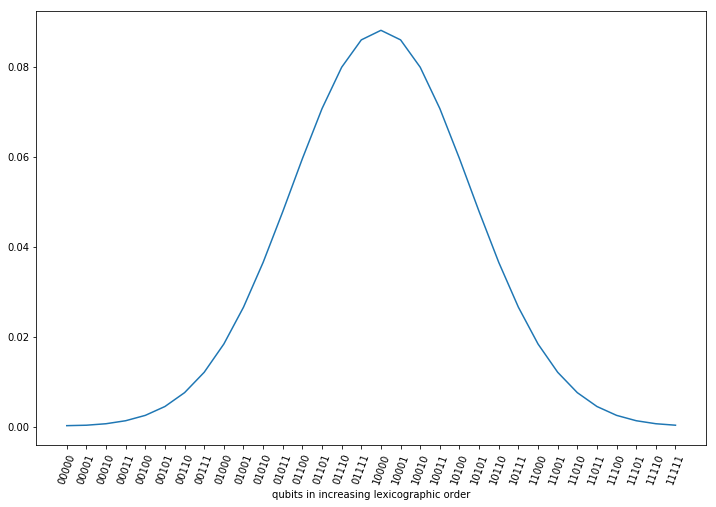

In [3]:
# plot_example(7, fig_size=(15, 12))
plot_example(5)